In [81]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import random
from itertools import combinations

In [82]:
def mapear_valor(x):
    mapeo = {"ENTAILMENT": 1, "NEUTRAL": 0, "CONTRADICTION":0}
    return mapeo.get(x, x)  # Si no está en el mapeo, devuelve el original


In [83]:
def convertirLabel(l):
    new_l=[]
    for a in l: 
        if (type(a)==type("a")):
            if a.upper() in ["ENTAILMENT","ENTAILMENT,","ENTAILS",'PROBABLE ENTAILMENT', 'PROBABLY ENTAILMENT']:
                new_l.append(1)
            elif a.upper() in ["NEUTRAL","NEUTRAL,"] :
                new_l.append(0)
            elif a.upper() in ["CONTRADICTION","CONTRADICTION,","CONTRADITION","CONTRADCTION","NOT_ENTAILMENT","NOT-ENTAILMENT","NOT ENTAILMENT"]:
                new_l.append(0)
            else:
                new_l.append(9)    
        else:
            new_l.append(9)
    return new_l

In [84]:
def convertir(l):
    new_l=[]
    for a in l:
        if (type(a)==type("a")):
            if a.upper() in ["ENTAILMENT","ENTAILMENT,","ENTAILS",'PROBABLE ENTAILMENT', 'PROBABLY ENTAILMENT']:
                new_l.append("ENTAILMENT")
            elif a.upper() in ["NEUTRAL","NEUTRAL,"] :
                new_l.append("CONTRADICTION")
            elif a.upper() in ["CONTRADICTION","CONTRADICTION,","CONTRADITION","CONTRADCTION","NOT_ENTAILMENT","NOT-ENTAILMENT","NOT ENTAILMENT"]:
                new_l.append("CONTRADICTION")
            else:
                new_l.append(9)    
        else:
            new_l.append(9)
    return new_l

# 

In [85]:
datasets = ["DIAG"]
models=["gemma2","gemma2:2b","llama3.1","llama3.2","phi3:medium","phi3"]

In [86]:
#combinations for G1,G2,G3,G4 -> three and two for scenarios failure
grupos=["G1","G2","G3","G4"]
combinationsGs = list(combinations(grupos, 3))
combinationsGs.extend(list(combinations(grupos, 2)))

In [87]:
#combinations for G1,G2,G3,G4   three and two
combinationsGs = list(combinations(grupos, 3))
combinationsGs.extend(list(combinations(grupos, 2)))

In [ ]:
labels=set()
for m in models:
    for d in datasets:
        print("Model",m,"dataset",d)
        corpus=d.lower()
        ruta=m+"/"+d+"/complete/"
        salida=m+"/"+d+"/answers/"
        data_g="../data/samples/"+d+"/"
        dt_data={'cv':[],'DT':[],'root':[],'deep':[],'parameters':[]}
        for i in range(5): # CV
            #TRAIN
            y_g = pd.read_pickle(data_g+corpus+"1.pickle")
            indexs = list(y_g[y_g["gold_label"]=="entailment"].sample(200,random_state=i).index)
            indexs.extend(list(y_g[y_g["gold_label"]!="entailment"].sample(200,random_state=i).index))
            train=convertir(y_g[y_g.index.isin(indexs)]["gold_label"].to_list())
            
            new_data = {}

            g1=pd.read_pickle(ruta+"rit_1_G1.pickle")
            g2=pd.read_pickle(ruta+"rit_1_G2.pickle")
            g3=pd.read_pickle(ruta+"rit_1_G3.pickle")
            g4=pd.read_pickle(ruta+"rit_1_G4.pickle")

            lista_respuestas_G1 = g1["Answer"].to_list()
            lista_respuestas_G2 = g2["Answer"].to_list()
            lista_respuestas_G3 = g3["Answer"].to_list()
            lista_respuestas_G4 = g4["Answer"].to_list()
            y_true = y_g["gold_label"].to_list()
            y_true = convertir(y_true)

            new_data["G1"]=convertir(lista_respuestas_G1)
            new_data["G2"]=convertir(lista_respuestas_G2)
            new_data["G3"]=convertir(lista_respuestas_G3)
            new_data["G4"]=convertir(lista_respuestas_G4)
            new_data["gold_label"]=y_true
            
            new_data = pd.DataFrame(new_data)
            
            labels=labels.union(set(lista_respuestas_G1))
            labels=labels.union(set(lista_respuestas_G2))
            labels=labels.union(set(lista_respuestas_G3))
            labels=labels.union(set(lista_respuestas_G4))

            #Checar aciertos para cada grupo
            #aciertos
            v_a_G1=[]
            v_a_G2=[]
            v_a_G3=[]
            v_a_G4=[]
            v_a_ST=[]
                    
            for index,strings in new_data.iterrows():
                if str(strings["G1"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G1.append(1)
                else:
                    v_a_G1.append(0)
                if str(strings["G2"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G2.append(1)
                else:
                    v_a_G2.append(0)
                if str(strings["G3"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G3.append(1)
                else:
                    v_a_G3.append(0)
                if str(strings["G4"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G4.append(1)
                else:
                    v_a_G4.append(0)

            # probar sobre la aportación de cada grupo
            new_data["G1_aciertos"]=v_a_G1
            new_data["G2_aciertos"]=v_a_G2
            new_data["G3_aciertos"]=v_a_G3
            new_data["G4_aciertos"]=v_a_G4
            
            new_data.to_pickle(salida+"cv"+str(i+1)+"/w_answers_s1.pickle")

            # SKA_DT
            dataset_train=new_data[new_data.index.isin(indexs)]

            data_X=dataset_train[["G1","G2","G3","G4"]].map(mapear_valor)
            data_Y=dataset_train["gold_label"].map(mapear_valor).values

            clf = DecisionTreeClassifier(random_state=i)
            clf.fit(data_X, data_Y)

            dt_data["cv"].append(i+1)
            #save parameters of DT
            dt_data["DT"].append("SKA_DT")
            dt_data["root"].append("G"+str(clf.feature_importances_.argmax()+1))
            dt_data["deep"].append(clf.get_depth())
            dt_data["parameters"].append(clf.get_params())
            
            # GS_DT combinatios three and two of G1,G2,G3,G4
            DT_comb_GS=[]
            
            for comb in combinationsGs:
                if len(comb)==3:
                    data_X=dataset_train[[comb[0],comb[1],comb[2]]].map(mapear_valor)
                elif len(comb)==2:
                    data_X=dataset_train[[comb[0],comb[1]]].map(mapear_valor)
                clf_gs = DecisionTreeClassifier(random_state=i)
                clf_gs.fit(data_X, data_Y)
                dt_data["cv"].append(i+1)
                #save parameters of DT
                dt_data["DT"].append(comb)
                dt_data["root"].append("G"+str(clf_gs.feature_importances_.argmax()+1))
                dt_data["deep"].append(clf_gs.get_depth())
                dt_data["parameters"].append(clf_gs.get_params())
                DT_comb_GS.append(clf_gs)
            # Weighted VM (weights)
            new_data_pesos={"sample":[],"alpha_G1":[],"alpha_G2":[],"alpha_G3":[],"alpha_G4":[],"sumaT":[]}
            
            df = dataset_train.copy()
            alpG1=1
            alpG2=1
            alpG3=1
            alpG4=1
            alpST=1
            for index,strings in df.iterrows():
                conteosE=0
                if strings["G1_aciertos"]==0:
                    conteosE+=1
                if strings["G2_aciertos"]==0:
                    conteosE+=1
                if strings["G3_aciertos"]==0:
                    conteosE+=1
                if strings["G4_aciertos"]==0:
                    conteosE+=1
                #print(conteosE)
                if strings["G1_aciertos"]==1:
                    alpG1+=conteosE/4
                if strings["G2_aciertos"]==1:
                    alpG2+=conteosE/4
                if strings["G3_aciertos"]==1:
                    alpG3+=conteosE/4
                if strings["G4_aciertos"]==1:
                    alpG4+=conteosE/4
            alpG1=np.round(alpG1,0)
            alpG2=np.round(alpG2,0)
            alpG3=np.round(alpG3,0)
            alpG4=np.round(alpG4,0)
            sumaT=alpG1+alpG2+alpG3+alpG4
            new_data_pesos["sample"].append(1)
            new_data_pesos["alpha_G1"].append(alpG1)
            new_data_pesos["alpha_G2"].append(alpG2)
            new_data_pesos["alpha_G3"].append(alpG3)
            new_data_pesos["alpha_G4"].append(alpG4)
            new_data_pesos["sumaT"].append(sumaT)

            new_data_pesos=pd.DataFrame(new_data_pesos)
            new_data_pesos.to_pickle(salida+"cv"+str(i+1)+"/alphas_4gs.pickle")
            pesos=new_data_pesos.mean().values[1:]

            # get results 
            new_dataR = {'group':[],'sample':[],'accuracy':[], 'matriz_confusion':[],
                'Contra_precision':[], 'Contra_recall':[], 'Contra_f1':[], 
                'Entail_precision':[], 'Entail_recall':[], 'Entail_f1':[],
                'CEntailment':[],'CContradiction':[],
                'G1_IVM':[],'G2_IVM':[],'G3_IVM':[],'G4_IVM':[]}

            new_data = {}

            temp=pd.read_pickle(ruta+"rit_Base_1.pickle")
            lista_respuestas_Base = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_DR_4r.pickle")
            lista_respuestas_DR = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_AR.pickle")
            lista_respuestas_AR = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp = pd.read_pickle(ruta+"ritB_SAoT1.pickle")
            lista_respuestas_AoT = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            #lista_respuestas_AoT_FS = pd.read_pickle(ruta+"ritB_AoT_FS1.pickle")["Answer"].to_list()
            temp = pd.read_pickle(ruta+"ritB_AoT1.pickle")
            lista_respuestas_CoT= temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_G1.pickle")
            lista_respuestas_G1 = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_G2.pickle")
            lista_respuestas_G2 = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_G3.pickle")
            lista_respuestas_G3 = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(ruta+"rit_1_G4.pickle")
            lista_respuestas_G4 = temp[~temp.index.isin(indexs)]["Answer"].to_list()
            temp=pd.read_pickle(data_g+corpus+"1.pickle")
            y_true = temp[~temp.index.isin(indexs)]["gold_label"].to_list()
            y_true = convertir(y_true)

            new_data["Base"]=convertir(lista_respuestas_Base)
            new_data["SAoT"]=convertir(lista_respuestas_AoT)
            new_data["DR"]=convertir(lista_respuestas_DR)
            new_data["AR"]=convertir(lista_respuestas_AR)
            #new_data["AoT_FS"]=convertir(lista_respuestas_AoT_FS)
            new_data["AoT"]=convertir(lista_respuestas_CoT)
            new_data["G1"]=convertir(lista_respuestas_G1)
            new_data["G2"]=convertir(lista_respuestas_G2)
            new_data["G3"]=convertir(lista_respuestas_G3)
            new_data["G4"]=convertir(lista_respuestas_G4)
            new_data["gold_label"]=y_true
            
            new_data = pd.DataFrame(new_data)

            labels=labels.union(set(lista_respuestas_Base))
            labels=labels.union(set(lista_respuestas_CoT))
            labels=labels.union(set(lista_respuestas_AR))
            #labels=labels.union(set(lista_respuestas_AoT_FS))
            labels=labels.union(set(lista_respuestas_G1))
            labels=labels.union(set(lista_respuestas_G2))
            labels=labels.union(set(lista_respuestas_G3))
            labels=labels.union(set(lista_respuestas_G4))
            
            #SKA_DT

            X_test=new_data[["G1","G2","G3","G4"]].map(mapear_valor)
            y_gold=new_data["gold_label"].map(mapear_valor).values

            y_pred=[]
            for a in clf.predict(X_test):
                y_pred.append(a)
            
            eti=[]
            for kas in y_pred:
                if(kas==1):
                    eti.append("ENTAILMENT")
                elif(kas==0):
                    eti.append("CONTRADICTION")

            new_data["SKA_DT"]=eti    

            # get results combinations
            m_gs=0
            for comb in combinationsGs:
                if len(comb)==3:
                    X_test=new_data[[comb[0],comb[1],comb[2]]].map(mapear_valor)
                elif len(comb)==2:
                    X_test=new_data[[comb[0],comb[1]]].map(mapear_valor)
                
                y_pred=[]
                for a in DT_comb_GS[m_gs].predict(X_test):
                    y_pred.append(a)
                
                eti=[]
                for kas in y_pred:
                    if(kas==1):
                        eti.append("ENTAILMENT")
                    elif(kas==0):
                        eti.append("CONTRADICTION")

                new_data[comb]=eti[:]
                m_gs+=1
            

            #Checar aciertos para cada grupo

            #aciertos
            v_a_G1=[]
            v_a_G2=[]
            v_a_G3=[]
            v_a_G4=[]
            v_a_ST=[]
            
            #voto majority
            v_m_G1=[]
            v_m_G2=[]
            v_m_G3=[]
            v_m_G4=[]
            v_m_ST=[]

            vote_majority=""
            wvote_majority=""
            v_m=[]
            wv_m=[]
            
            for index,strings in new_data.iterrows():
                votos=[]
                votos.append(str(strings["G1"]).upper())
                votos.append(str(strings["G2"]).upper())
                votos.append(str(strings["G3"]).upper())
                votos.append(str(strings["G4"]).upper())

                if str(strings["G1"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G1.append(1)
                else:
                    v_a_G1.append(0)
                if str(strings["G2"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G2.append(1)
                else:
                    v_a_G2.append(0)
                if str(strings["G3"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G3.append(1)
                else:
                    v_a_G3.append(0)
                if str(strings["G4"]).upper()==str(strings["gold_label"]).upper():
                    v_a_G4.append(1)
                else:
                    v_a_G4.append(0)

                if votos.count("ENTAILMENT")>2:
                    v_m.append("ENTAILMENT")
                    vote_majority="ENTAILMENT"
                elif votos.count("CONTRADICTION")>2:
                    v_m.append("CONTRADICTION")
                    vote_majority="CONTRADICTION"
                else:
                    random.seed(index)
                    random_choice = random.choice(["ENTAILMENT","CONTRADICTION"])
                    v_m.append(random_choice)
                    vote_majority=random_choice

                # que grupo aporta a VM
                if votos[0]==vote_majority:
                    v_m_G1.append(1)
                else:
                    v_m_G1.append(0)
                if votos[1]==vote_majority:
                    v_m_G2.append(1)
                else:
                    v_m_G2.append(0)
                if votos[2]==vote_majority:
                    v_m_G3.append(1)
                else:
                    v_m_G3.append(0)
                if votos[3]==vote_majority:
                    v_m_G4.append(1)
                else:
                    v_m_G4.append(0)

                
                pEntail=0
                pContra=0
                for k in range(4):
                    if "ENTAILMENT" in votos[k]:
                        pEntail+=pesos[k]
                    elif "CONTRADICTION" in votos[k]:
                        pContra+=pesos[k]
                if pEntail>pContra:
                    wvote_majority="ENTAILMENT"
                elif pContra>pEntail:
                    wvote_majority="CONTRADICTION"
                else:
                    wvote_majority="NA"
                wv_m.append(wvote_majority)
            # 

            new_data["SKA_MV"]=v_m
            new_data["SKA_WMV"]=wv_m
            new_data["G1_aciertos"]=v_a_G1
            new_data["G2_aciertos"]=v_a_G2
            new_data["G3_aciertos"]=v_a_G3
            new_data["G4_aciertos"]=v_a_G4
            new_data["G1_IVM"]=v_m_G1
            new_data["G2_IVM"]=v_m_G2
            new_data["G3_IVM"]=v_m_G3
            new_data["G4_IVM"]=v_m_G4       

            new_data.to_pickle(salida+"cv"+str(i+1)+"/answers_s1.pickle")

            #results       
            temp=new_data.copy()
            y_true=convertirLabel(temp["gold_label"])

            coln_new=["Base","DR","AR","SAoT","AoT","SKA_MV","SKA_WMV","SKA_DT","G1","G2","G3","G4"]
            coln_new.extend(combinationsGs)
            columData=["Base","DR","AR","SAoT","AoT","SKA_MV","SKA_WMV","SKA_DT","G1","G2","G3","G4"]
            columData.extend(combinationsGs)
            l=0
            for coln in columData:
                y_pred=convertirLabel(temp[coln])
                
                y_gold=[]
                y_predF=[]
                for valor in range(len(y_pred)):
                    if y_pred[valor]!=9:
                        y_gold.append(y_true[valor])
                        y_predF.append(y_pred[valor])
                
                info=classification_report(y_gold, y_predF,output_dict=True)
                new_dataR["CEntailment"].append(info['1']['support'])
                new_dataR["CContradiction"].append(info['0']['support'])

                new_dataR["group"].append(coln_new[l])
                new_dataR["sample"].append(1)
                new_dataR["accuracy"].append(info['accuracy'])
                new_dataR["G1_IVM"].append(np.mean(temp["G1_IVM"].values))
                new_dataR["G2_IVM"].append(np.mean(temp["G2_IVM"].values))
                new_dataR["G3_IVM"].append(np.mean(temp["G3_IVM"].values))
                new_dataR["G4_IVM"].append(np.mean(temp["G4_IVM"].values))
                new_dataR["matriz_confusion"].append(confusion_matrix(y_gold, y_predF))
                new_dataR["Contra_precision"].append(info['0']['precision'])
                new_dataR["Contra_recall"].append(info['0']['recall'])
                new_dataR["Contra_f1"].append(info['0']['f1-score'])
                new_dataR["Entail_precision"].append(info['1']['precision'])
                new_dataR["Entail_recall"].append(info['1']['recall'])
                new_dataR["Entail_f1"].append(info['1']['f1-score'])
                l+=1

            new_dataR=pd.DataFrame(new_dataR)
            new_dataR.to_pickle(salida+"cv"+str(i+1)+"/results.pickle")
        pd.DataFrame(dt_data).to_pickle(salida+"parametersDT.pickle")
print(labels)


Model gemma2 dataset DIAG
Model gemma2:2b dataset DIAG
Model llama3.1 dataset DIAG
Model llama3.2 dataset DIAG
Model phi3:medium dataset DIAG
Model phi3 dataset DIAG
{'', 'NA', 'Contradiction', 'Neutral', 'Entailment'}


In [89]:
for m in models:
    for d in datasets:
        salida=m+"/"+d+"/answers/"
        paraDT=pd.read_pickle(salida+"/parametersDT.pickle")
        print("Model",m,"dataset",d,paraDT[paraDT["DT"]=="SKA_DT"]["root"].unique(),paraDT[paraDT["DT"]=="SKA_DT"]["deep"].describe()["mean"])

Model gemma2 dataset DIAG ['G4' 'G1'] 5.2
Model gemma2:2b dataset DIAG ['G4' 'G1'] 5.2
Model llama3.1 dataset DIAG ['G4'] 4.0
Model llama3.2 dataset DIAG ['G1'] 4.2
Model phi3:medium dataset DIAG ['G4'] 4.0
Model phi3 dataset DIAG ['G4' 'G1'] 4.0


# Figures 

In [90]:
results_dic={}
for m in models:
    for d in datasets:
        corpus=d.lower()
        ruta=m+"/"+d+"/complete/"
        salida=m+"/"+d+"/answers/"
        data_g="../data/samples/"+d+"/"
        new_data1=pd.read_pickle(salida+"cv1/results.pickle")
        new_data2=pd.read_pickle(salida+"cv2/results.pickle")
        new_data3=pd.read_pickle(salida+"cv3/results.pickle")
        new_data4=pd.read_pickle(salida+"cv4/results.pickle")
        new_data5=pd.read_pickle(salida+"cv5/results.pickle")
        all=pd.concat([new_data1,new_data2,new_data3,new_data4,new_data5],axis=0)
        results_dic[m+"_"+d]=all
        for p in columData:
            if d=="DIAG":
                if (all[all["group"]==p]["CEntailment"].describe().at["min"]<250):
                    print(m,d,p,"CEntailment")
                elif (all[all["group"]==p]["CContradiction"].describe().at["min"]<434):
                    print(m,d,p,"CContradiction")

phi3 DIAG SAoT CEntailment
phi3 DIAG AoT CEntailment


In [91]:
data_md=results_dic["llama3.2_DIAG"]

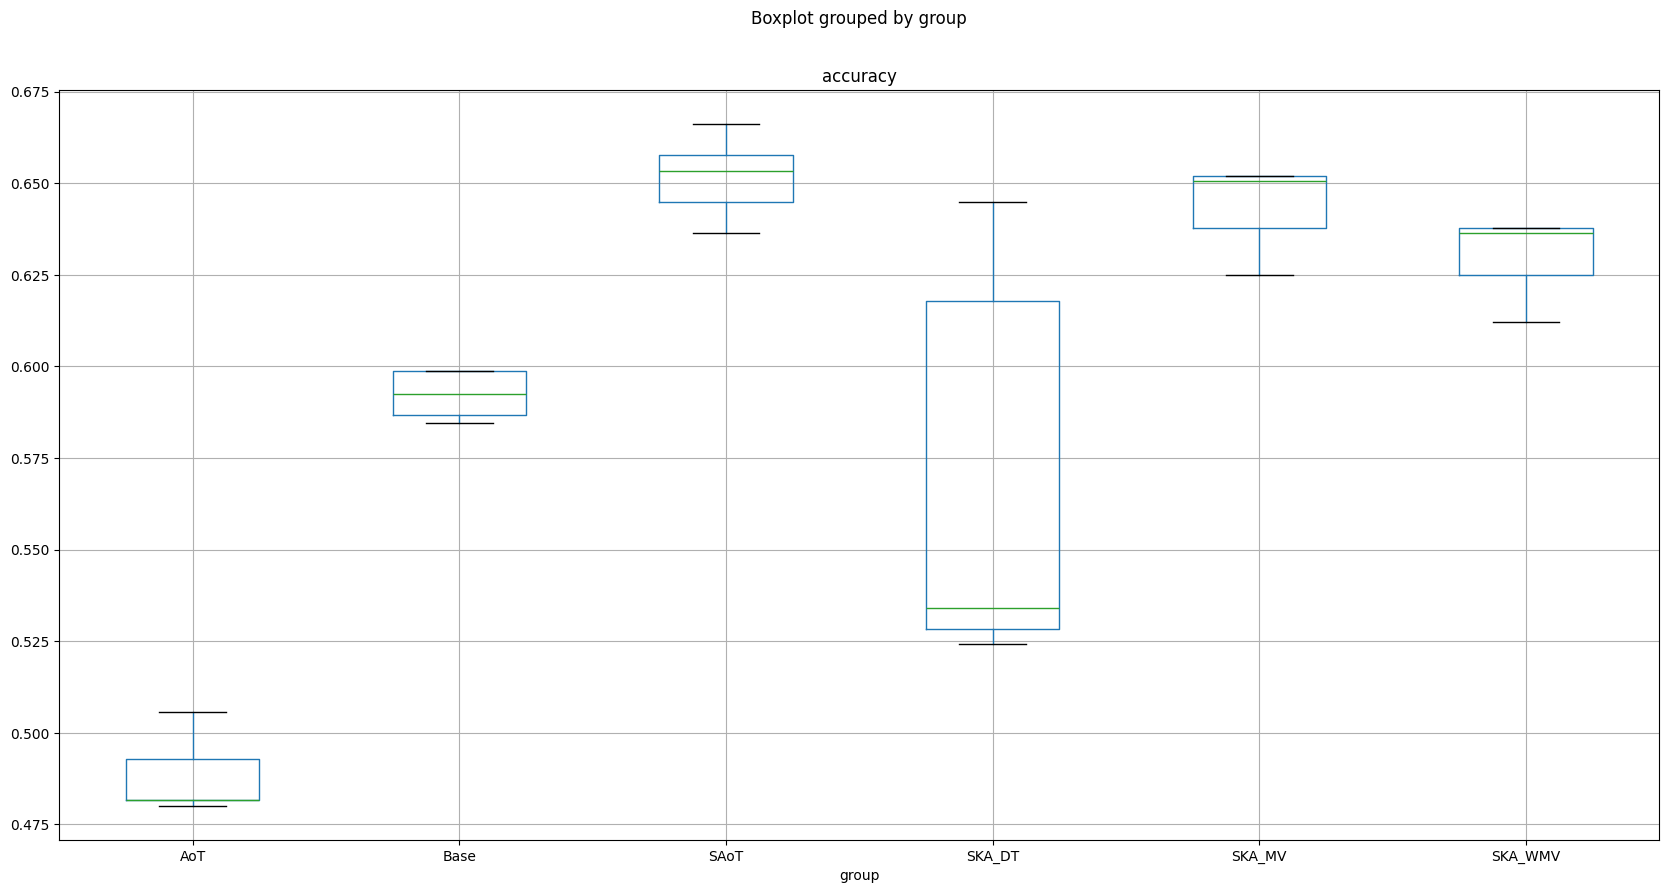

In [92]:
data_md[data_md["group"].isin(["Base","AoT","SAoT","SAoT_FS","SKA_DT","SKA_MV","SKA_WMV"])].boxplot(by ='group', column =['accuracy'], grid = True,figsize=(20,10))
plt.show()

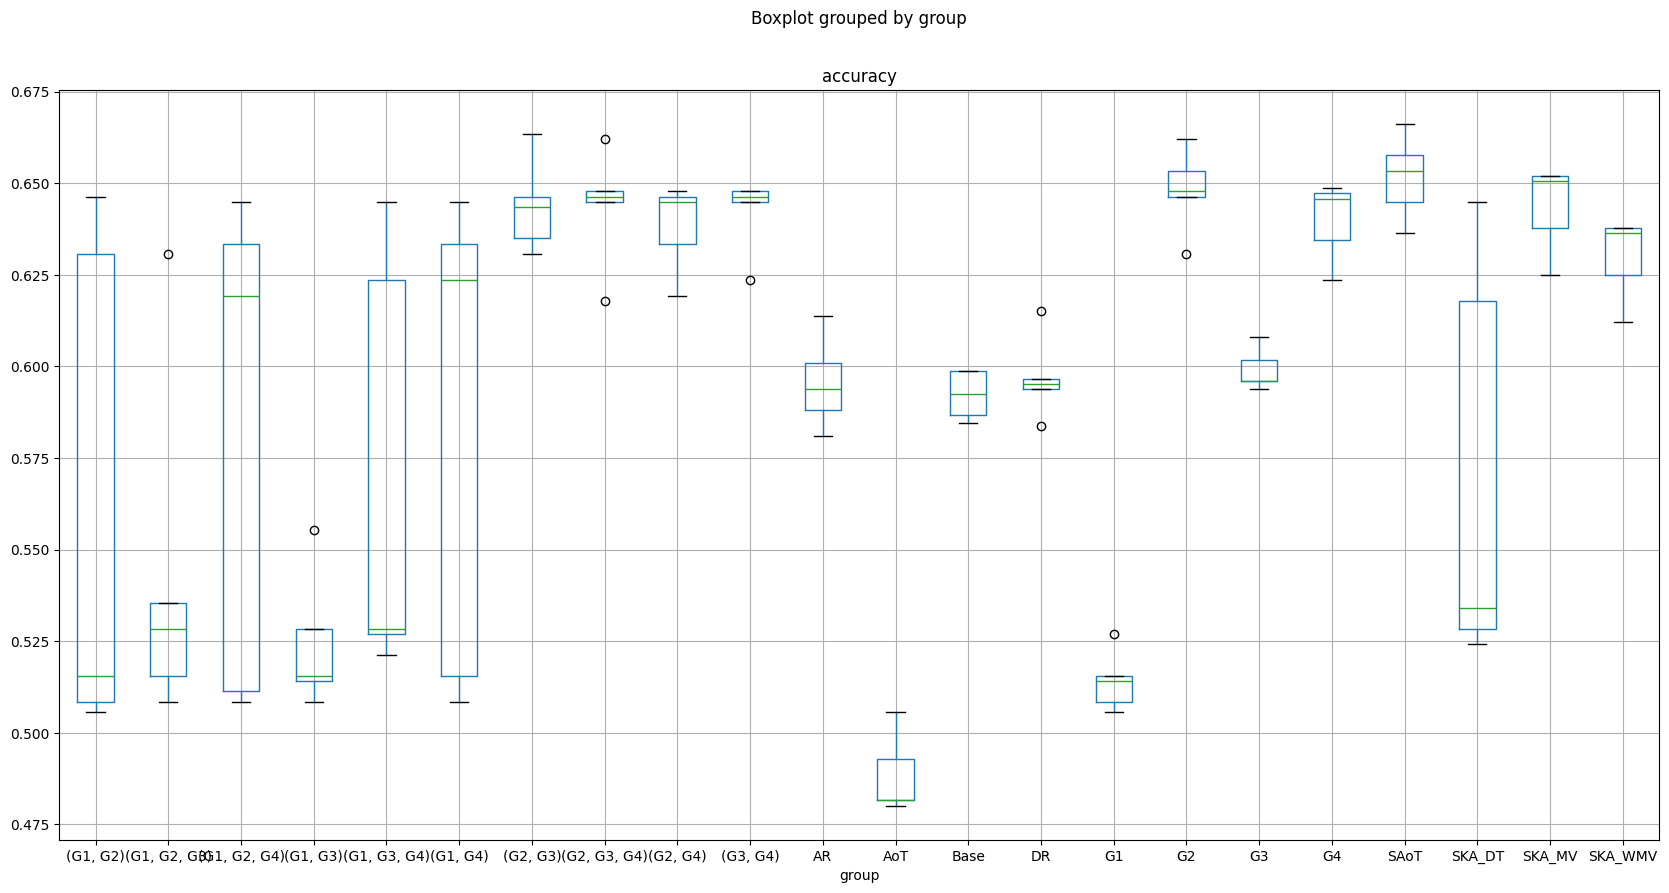

In [93]:
data_md.boxplot(by ='group', column =['accuracy'], grid = True,figsize=(20,10))
plt.show()

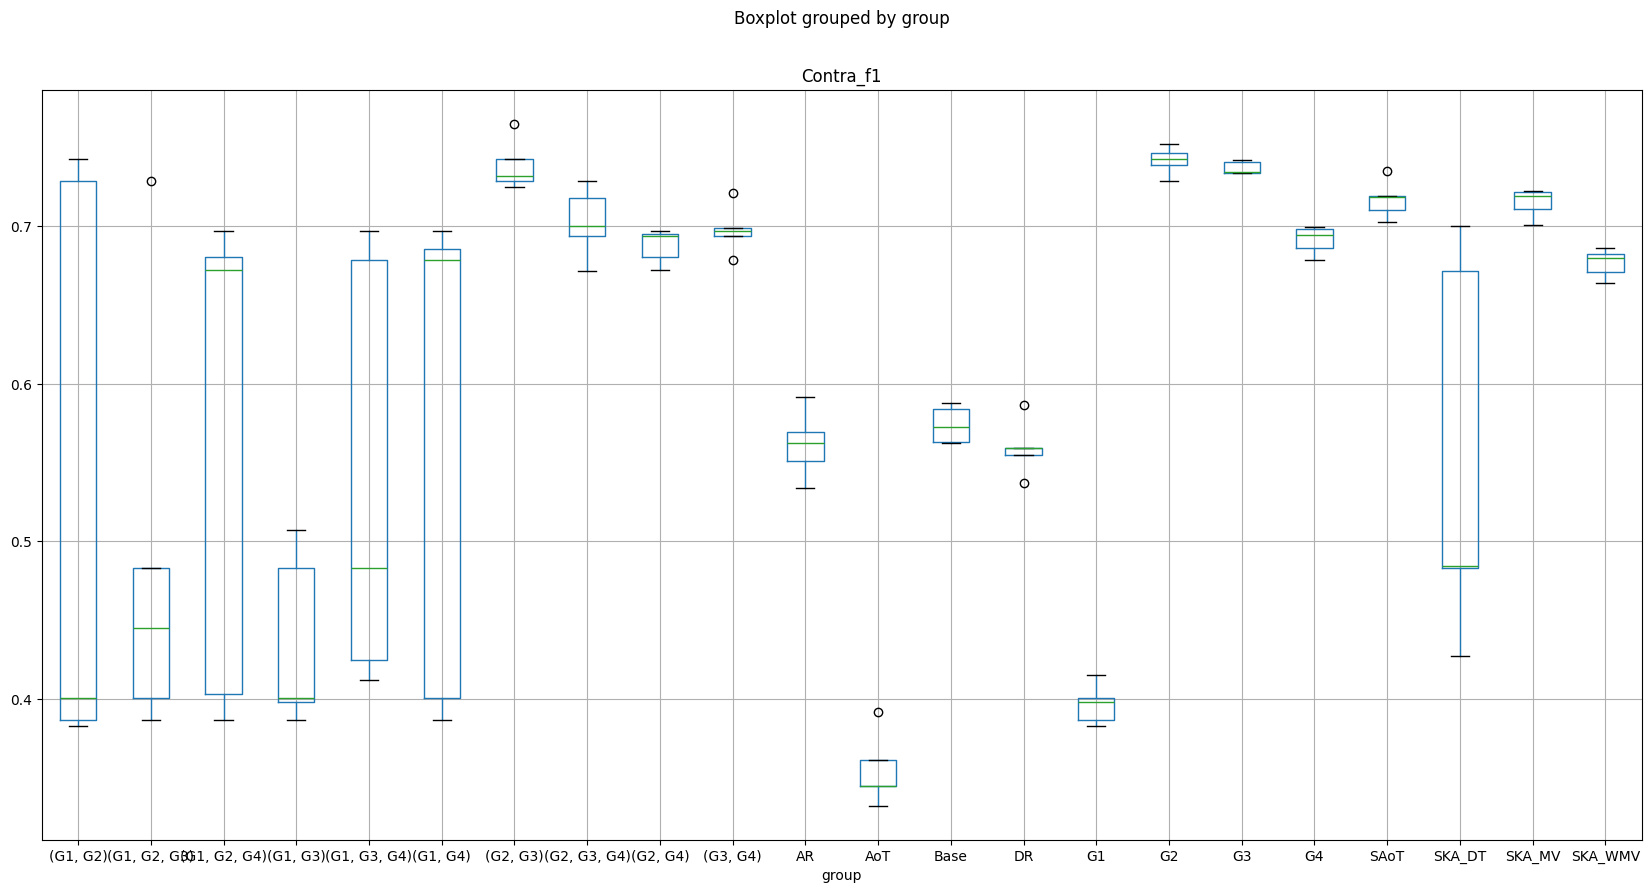

In [94]:
data_md.boxplot(by ='group', column =['Contra_f1'], grid = True,figsize=(20,10))
plt.show()

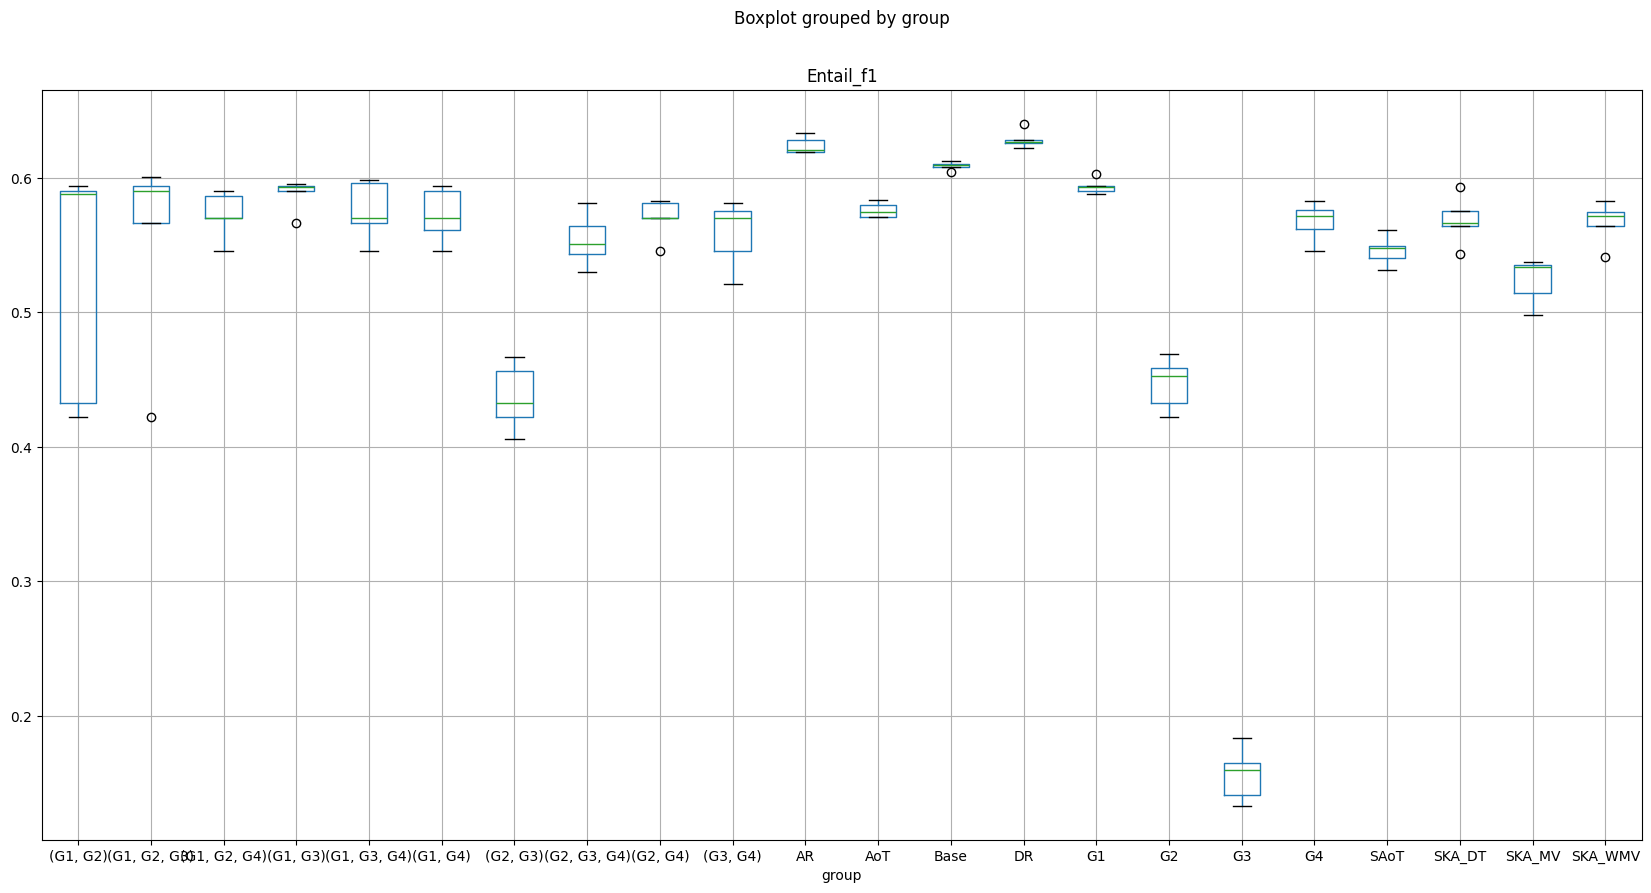

In [95]:
data_md.boxplot(by ='group', column =['Entail_f1'], grid = True,figsize=(20,10))
plt.show()